### Imports

In [23]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from models.autoencoder import ConvolutionalEncoderSmall, IndependentVarianceDecoderSmall
from models.nae_external import ExternalLatentAutoEncoder
from bijectors.masked_autoregressive_transform import get_masked_autoregressive_transform

from util import dequantize

from nflows.transforms import InverseTransform, AffineTransform, IdentityTransform

from bijectors.actnorm import ActNorm
from bijectors.sigmoid import Sigmoid

### Data

In [8]:
transform = transforms.ToTensor()

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

9913344it [00:00, 12134524.27it/s]                                                                                     


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



29696it [00:00, ?it/s]                                                                                                 


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



1649664it [00:00, 13477038.28it/s]                                                                                     


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



5120it [00:00, ?it/s]                                                                                                  


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



### Network
To define our model we require an encoder and decoder, and two normalizing flows. We choose a simple convolutional encoder which outputs a mean and standard deviation, a simple convolutional decoder with a learnable variance, and two masked autoregressive flows.

In [35]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

hidden_channels = 64
img_shape = [1, 28, 28]
alpha = 1e-6
latent_dims = 2

encoder = ConvolutionalEncoderSmall(hidden_channels, img_shape, latent_dims)
decoder = IndependentVarianceDecoderSmall(hidden_channels, img_shape, latent_dims)

flow_features = 256
num_layers = 4
core_encoder = get_masked_autoregressive_transform(features=latent_dims, hidden_features=flow_features, num_layers=num_layers,
                                                   num_blocks_per_layer=2, act_norm_between_layers=True)

prior_flow = get_masked_autoregressive_transform(features=latent_dims, hidden_features=flow_features, num_layers=num_layers,
                                                   num_blocks_per_layer=2, act_norm_between_layers=True)

#preprocessing_layers = [InverseTransform(AffineTransform(alpha, 1 - 2 * alpha)), Sigmoid(),
#                            ActNorm(img_shape[0])]
preprocessing_layers = []

aef = ExternalLatentAutoEncoder(encoder, decoder, core_encoder, prior_flow, preprocessing_layers=preprocessing_layers)
aef = aef.to(device)

### Training

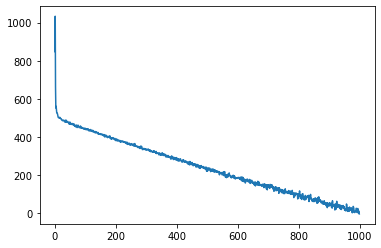

In [36]:
optimizer = torch.optim.Adam(params=aef.parameters(), lr=1e-3)

n_iterations = 1000
stop = False

losses = []

stop = False
n_iters_done = 0
while not stop:
    for image_batch, _ in trainloader:
        image_batch = dequantize(image_batch)
        image_batch = image_batch.to(device)

        loss = torch.mean(aef.loss_function(image_batch))
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        n_iters_done += 1
        if n_iters_done >= n_iterations:
            stop = True
            break
plt.plot(range(n_iterations), losses)

In [ ]:
aef.eval()
test_losses = np.zeros((len(testloader)))
with torch.no_grad():
    for batch_idx, test_batch, _ in enumerate(test_dataloader):
        test_batch = dequantize(test_batch)
        test_batch = test_batch.to(device)
        loss = torch.mean(aef.loss_function(test_batch))
        test_losses[batch_idx] = loss.item()
